# Bees classifier

I was looking for a data set to learn how to use keras to do convolutionnal neural nets. The challenge provided by DrivenData
is a binary classification of pictures of bees. Si

The benchmark for this competition is given at [DrivenData](http://blog.drivendata.org/2015/09/24/bees-benchmark/).

## 1. Reading and processing the data

Since the competition is completed, I can only work with the train data which has been labeled. I thus read the picture following the id of the labels. Then I split the pictures into three set (train, validation, test) with proportion (0.8, 0.1, 0.1). Since the negative class is underrepresented, I over sample it to reach a 43% ratio in the training data. Even by keeping the same pictures, it improved the performance on that class. 

***
1. Read the images
2. Split into three sets (train, validation, test)
3. Over sample the negative class for the training set
***

### Reading the data

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import imread

%matplotlib inline

In [2]:
# list the contents of the data directory
!tree --filelimit=30

.
├── bees
│   ├── images
│   │   ├── test [992 entries exceeds filelimit, not opening dir]
│   │   └── train [3969 entries exceeds filelimit, not opening dir]
│   ├── SubmissionFormat.csv
│   └── train_labels.csv
└── bees_benchmark_keras-Conv-pre-trained.ipynb

4 directories, 3 files


In [3]:
# load the labels using pandas
labels = pd.read_csv("bees/train_labels.csv")

submission_format = pd.read_csv("bees/SubmissionFormat.csv",
                                index_col=0)

print( "Number of training examples is: ", labels.shape[0])
print( "Predictions should be type:", labels.dtypes[0])
labels.head()

Number of training examples is:  3969
Predictions should be type: int64


,id,genus
0,520,1.0
1,3800,1.0
2,3289,1.0
3,2695,1.0
4,4922,1.0


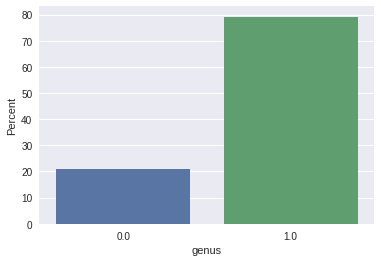

In [4]:
ax = sns.barplot(x="genus", y="genus", data=labels, estimator=lambda x: len(x) / len(labels) * 100)
ax.set(ylabel="Percent")

In [5]:
# let's see what's in one of the image folders
!ls bees/images/train/ | head -n 10

1000.jpg
1002.jpg
1003.jpg
1004.jpg
1007.jpg
1008.jpg
1009.jpg
100.jpg
1010.jpg
1011.jpg
ls: erreur d'écriture: Relais brisé (pipe)


In [6]:
labels.sort_values(by='id',inplace =True)

In [7]:
from scipy.misc import imread

temp = []
skip_img = []

#x = os.listdir("./bees/images/test/")
for img_number in labels.id.values :
    
    
        image_path = os.path.join("./bees/images/train/", str(img_number) + ".jpg")
        
        try:
            img = imread(image_path, mode = 'RGB')
            #print(img_number)
            img = img.astype('float32')
            
        except:
            labels.drop(labels[labels.id == img_number].index, inplace=True)
            continue
            
        if img.size != 120000 :
            print("the id is {0} and the size is {1}".format(img_number, img.size))
            skip_img.append(img_number)
            labels.drop(labels[labels.id == img_number].index, inplace=True)
            continue
        
        temp.append(img)
        

training_images = np.stack(temp)
training_images /= 255.0

### Looking at the bees !

Let's look a bit at the pictures to see what we are going to be dealing with. 

In [56]:
from math import sqrt
def display_random_data_sets(training_set,labels,label_wanted,title):
        """
        the for loop is made to stacked the picture on horizontal lines and then on
        vertical layers when multiple of ten.
        """

        number_of_set_wanted = 9
        size = training_set.shape[1]
        training_set = training_set[labels == label_wanted]
        
        randomly_selected_indices = np.random.randint(training_set.shape[0], size=number_of_set_wanted)

        randomlySelected_data_sets = training_set[randomly_selected_indices, :]
        randomlySelected_data_sets = randomlySelected_data_sets.reshape((number_of_set_wanted, size, size,3))#, order='F')

        stacked_data_sets = np.zeros([size, int((sqrt(number_of_set_wanted) + 1) * size), 3])
        horizontal_stack = np.zeros([size, size,3])

        for set in range(number_of_set_wanted):

            horizontal_stack = np.hstack((horizontal_stack, randomlySelected_data_sets[set]))

            if (set + 1) % int(sqrt(number_of_set_wanted)) == 0:
                stacked_data_sets = np.vstack((stacked_data_sets, horizontal_stack))
                horizontal_stack = np.zeros([size, size,3])

        stacked_data_sets = stacked_data_sets[size:, size:,:]
        
        plt.figure(figsize=(10,10))
        plt.title(title, fontsize=25)
        plt.imshow(stacked_data_sets)
        plt.show()
        plt.close()

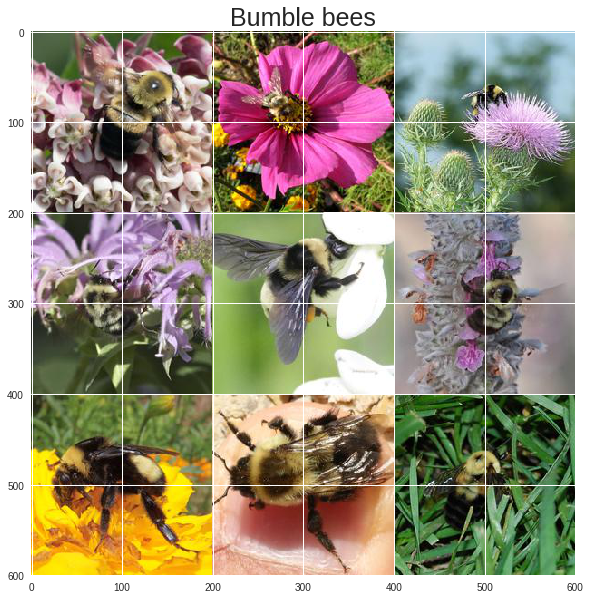

In [57]:
display_random_data_sets(training_set=training_images,labels =labels.genus.values, label_wanted=1, title = "Bumble bees")

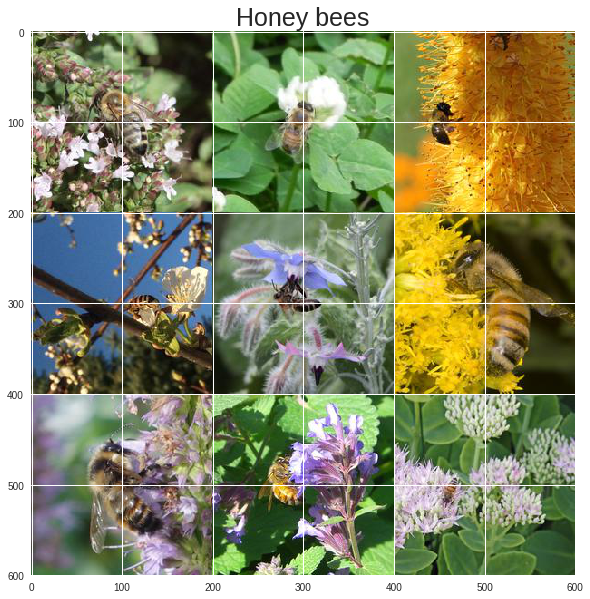

In [58]:
display_random_data_sets(training_set=training_images,labels =labels.genus.values, label_wanted=0, title = "Honey bees")

### Splitting the data

In [8]:
from sklearn.cross_validation import train_test_split

# split into a local train/test set
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(training_images,
                                                    labels.genus.values,
                                                    test_size=0.2,
                                                    random_state=102
                                                    )

/home/louis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                    y_test_and_val,
                                                    test_size=0.5,
                                                    random_state=102
                                                    )

### Over sampling the minority class

In [10]:
negative_examples_images = X_train[y_train == 0]

for i in range(2):
    
    np.take(negative_examples_images,np.random.permutation(negative_examples_images.shape[0]),axis=0,out=negative_examples_images);
    X_train = np.concatenate((X_train, negative_examples_images), axis=0)
    
    new_labels = np.full(negative_examples_images.shape[0], 0)
    y_train = np.concatenate((y_train, new_labels), axis=0)

In [11]:
X_train, X_empty, y_train, y_empty = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.0,
                                                    random_state=102)

### Checking the new ratio

In [12]:
neg_train = 100*np.sum(y_train == 0)/len(y_train)
neg_val = 100*np.sum(y_val == 0)/len(y_val)
neg_test = 100*np.sum(y_test == 0)/len(y_test)
print("negative train label: {0} %".format(neg_train))
print("negative val label: {0} %".format(neg_val))
print("negative test label: {0} %".format(neg_test))

negative train label: 43.52783366867874 %
negative val label: 21.410579345088163 %
negative test label: 23.425692695214106 %


## 2. Training 

I started my trainging with more simple models and then added complexity. Since the goal of the mini-project was to learn to use keras (with tensorflow), I used variation of NN. Here's the progression I used:

1. 1-hidden layer of a Multilayer Perceptron with greyscales
2. Convolutionnal Neural Network with greyscales
3. Convolutionnal Neural Network with colors
4. Pretrained VGG16 model with training only on two added layers
5. Pretrained InceptionV3 model with training only on two added layers
6. Pretrained InceptionV3 model with tfull training (only one present here)

I obviouly twiked the meta-parameters to improve the performance. I started by overfitting the train set. Then I overcorrected with to high bias solution by using too much regularization. The present solution might have some variance. If that would be the case, I probably would try a majority vote to see if multiple solution are complementary. Anyhow, the main parts of this section are to:

1. Define the model
2. Compile the model
3. Fit the model 

In [13]:
import keras

from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Dropout, Flatten

from sklearn.metrics import log_loss
from keras.models import Model

Using TensorFlow backend.


In [14]:
# The next two cell can be ommited by just loading the model 
#from keras.models import load_model
#model = load_model('my_model_2.h5')

### Define the model

In [15]:
# input and outputs specification
img_rows, img_cols = 200, 200 # Resolution of inputs
channel = 3
num_classes = 2 

# change the labels to categorical (necessary even with two classes when using categorical cross-entropy as loss)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)


#Get the InceptionV3 model as our base model
base_model =  InceptionV3(weights='imagenet', include_top=False)


#Uncomment the two following lines if you don't what to train the base model
#for layer in base_model.layers:
 #  layer.trainable = False
    
#Create your own input format 
input = Input(shape=(img_rows,img_cols,channel),name = 'image_input')

#Use the generated model 
output_base_model= base_model(input)

#Add the top layers 
x = Flatten(name='flatten')(output_base_model)
x = Dropout(0.2)(x)
x = Dense(512, 
          activation='relu',
          name='fc1',
          kernel_regularizer=keras.regularizers.l2(1e-6)
         )(x)
x = Dropout(0.4)(x)
x = Dense(512, 
          activation='relu',
          name='fc2',
          kernel_regularizer=keras.regularizers.l2(1e-6)
         )(x)
x = Dropout(0.4)(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)


model = Model(input=input, output=x)

#In the summary, weights and layers from InceptionV3 part will be hidden, but they will be fit during the training
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 200, 200, 3)       0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               16777728  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
__________

/home/louis/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


### Compile the model

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### fit the model

I used my laptop with 16 Go of ram and a NVIDIA GPU [GeForce GTX 960M]. The dropout <sup>[[1]](#myfootnote1)</sup> and regularization seems to prevent overfitting but there is still variance in the model. I reach an accuracy of 95% on the validation set and test set by running the fit with earling stopping twice. It takes less than an hour of training so there is probably still juice to press out of this lemon. That being said, my goal was to reach aroung 90% accuracy to make sure that I beated the class imbalance. 

<a name="myfootnote1">[1]</a>: Srivastava and al,["Dropout: A Simple Way to Prevent Neural Networks from Overfitting "](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf), 15(Jun):1929−1958, 2014
   

In [27]:
batch_size = 15
nb_epoch = 30

earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto', min_delta=0.0001)

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          shuffle=True,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[earlyStopping])


Train on 4473 samples, validate on 397 samples
Epoch 1/30
4473/4473 [==============================] - 225s - loss: 0.0271 - acc: 0.9920 - val_loss: 1.0578 - val_acc: 0.8715

## 3. Prediction and evaluation 

1. loss and accuracy
2. confusion matrix
3. classification report
4. plots of loss,accuracy versus epochs

### loss and accuracy

In [29]:
score = model.evaluate(X_test, keras.utils.to_categorical(y_test, 2), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.179507350325
Test accuracy: 0.96725440806


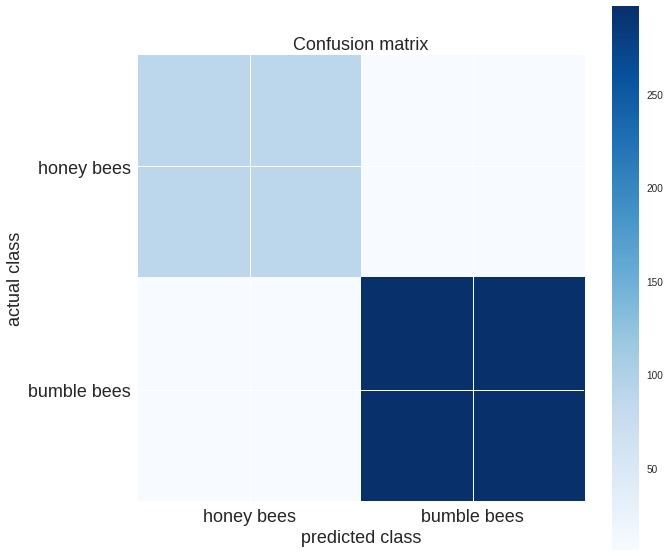

array([[ 87,   6],
       [  7, 297]])

In [61]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
labels  = ["honey bees","bumble bees"]

cnf_matrix =confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.set_title('Confusion matrix', fontsize=18)

ax.set_xlabel('predicted class', fontsize=18)
ax.set_ylabel('actual class', fontsize=18)

plt.xticks(range(len(labels)), labels, fontsize=18)
plt.yticks(range(len(labels)), labels, fontsize=18)

plt.imshow(cnf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.show()

confusion_matrix(y_test, y_pred)

In [62]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.93      0.94      0.93        93
        1.0       0.98      0.98      0.98       304

avg / total       0.97      0.97      0.97       397



### Plots accuracy,loss versus epochs

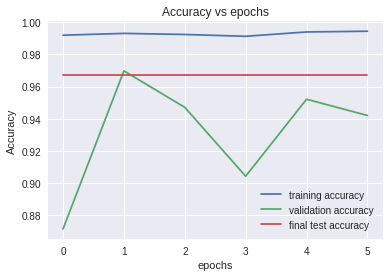

In [63]:
plt.title("Accuracy vs epochs")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
epochs = range(len(model.history.history["acc"]))

plt.plot(epochs,model.history.history["acc"])
plt.plot(epochs,model.history.history["val_acc"]) 
plt.plot(epochs,[score[1] for number in range(len(epochs))]) 

plt.legend(["training accuracy","validation accuracy", "final test accuracy"],loc="best")
plt.show()

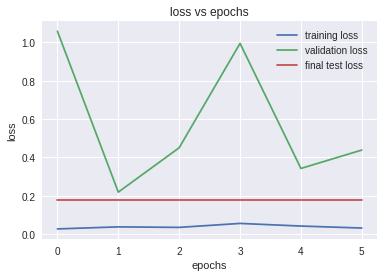

In [64]:
plt.title("loss vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
epochs = range(len(model.history.history["loss"]))

plt.plot(epochs,model.history.history["loss"])
plt.plot(epochs,model.history.history["val_loss"]) 
plt.plot(epochs,[score[0] for number in range(len(epochs))]) 

plt.legend(["training loss","validation loss", "final test loss"],loc="best")
plt.show()

In [65]:
#model.save('model_inception_full_training.h5')